# Super-resolution UNET

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from fastai.vision.gan import *

from PIL import Image as PILImage

---

In [2]:
batch_size = 8
bs = batch_size

# unet encoder architecture
arch = models.resnet34

image_size = 256

# Create the data loader (ImageDataBunch)

In [3]:
xform = get_transforms(
    do_flip = True,
    flip_vert = True,
    max_rotate = None,
    max_zoom = 1,
    max_lighting = None,
    max_warp = None,
)

data_loader = (
    ImageImageList.from_folder('../images/')
    .filter_by_func(lambda path: 'lowres' in path.parent.as_posix()) # filter to have only /lowres/ as source
    .split_by_folder()                                               # use the folders to split in train/valid
    .label_from_func(lambda path: path.parents[1]/'hires'/path.name) # change /lowres/ to /hires/ to match source with target
    
    .transform(xform, size=image_size, tfm_y=True)
    
    .databunch(bs=batch_size)
    .normalize(imagenet_stats, do_x=True, do_y=True) # convert the LabelLists in ImageDataBunch and normalize to imagenet both X and Y
)

# number of classes
# I don't know why 3 (based on lesson7-superres-gan notebooks)... 
# the unet_learner need a value for c.
data_loader.c = 3

data_loader

ImageDataBunch;

Train: LabelList
y: ImageItemList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Valid: LabelList
y: ImageItemList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Test: None

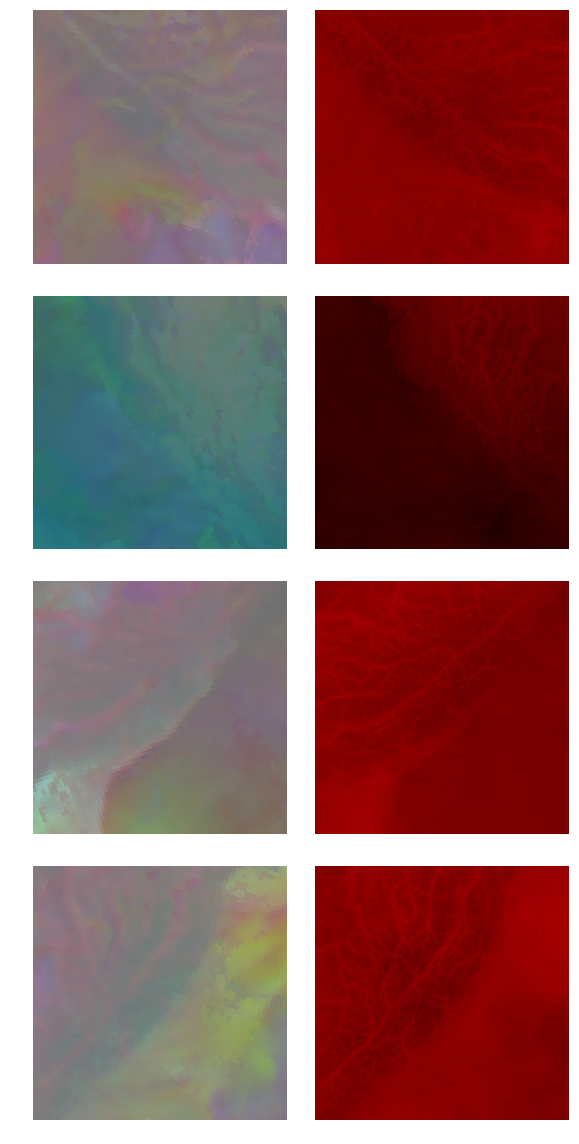

In [4]:
data_loader.show_batch(4)

---

# UNET

In [5]:
# weight decay
wd = 1e-3

y_range = (-3.,3.)

loss_gen = MSELossFlat()

---

In [6]:
def create_gen_learner():
    return unet_learner(data_loader, arch, 
                        wd=wd, blur=True, norm_type=NormType.Weight, self_attention=True, 
                        y_range=y_range, loss_func=loss_gen)

In [7]:
learn_gen = create_gen_learner()

---

## Pre-train the Generator

In [8]:
learn_gen.load('generator-pretrain-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Valid: LabelList
y: ImageItemList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size

In [8]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss
1,0.013353,0.010454
2,0.004515,0.004038


In [9]:
learn_gen.save('generator-pretrain-1')

---

## Unfreeze and train some more

In [9]:
learn_gen.unfreeze()

In [10]:
learn_gen.fit_one_cycle(200, slice(1e-6,1e-3))

epoch,train_loss,valid_loss
1,0.004084,0.003891
2,0.004030,0.003735
3,0.003965,0.003580
4,0.003881,0.003599
5,0.003752,0.003519
6,0.003841,0.003523
7,0.003734,0.003489
8,0.003658,0.003390
9,0.003496,0.003270
10,0.003573,0.003356


In [11]:
learn_gen.save('generator-pretrain-200-xform')

---

## Show results

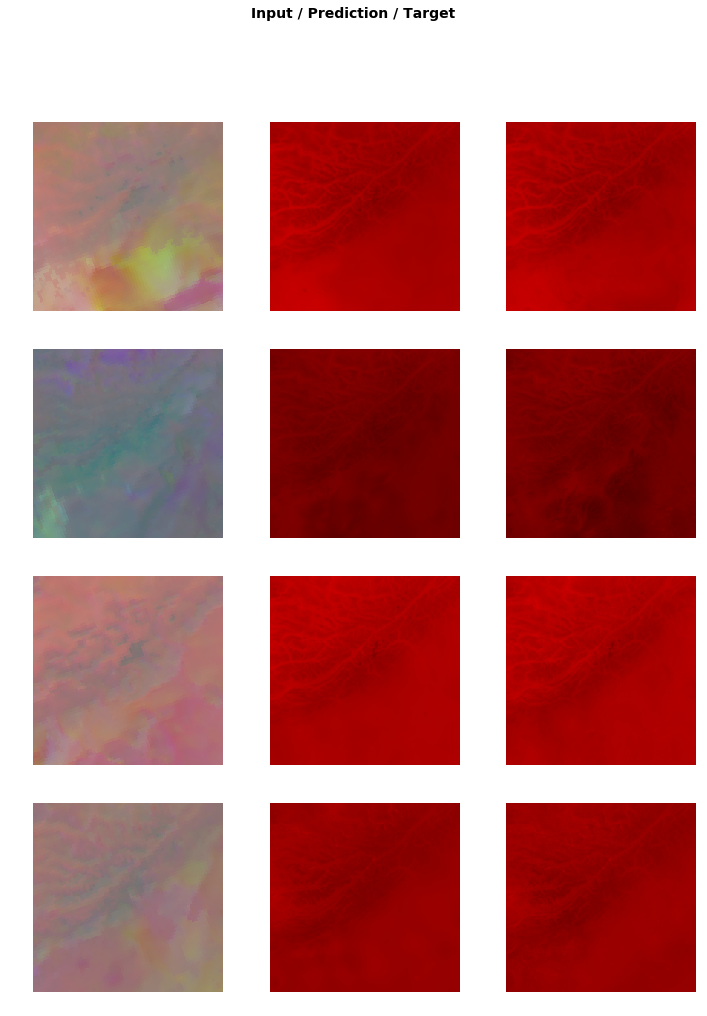

In [12]:
learn_gen.show_results(rows=4)

# Save Generated Images

In [9]:
learn_gen.load('generator-pretrain-50')

Learner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (5343 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Valid: LabelList
y: ImageItemList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images
x: ImageImageList (248 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: ../images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size

In [13]:
def get_temperature_vector(channel_vector, min_value, max_value):
    """
    Returns a (256,256) float vector ranging from [min_value, max_value].
    
    Arguments:
        channel_vector: a channel with values between [0, 1] 
        min_value: integer, the minimum value of the entire distribution of the vector to return
        max_value: integer, the maximum value of the entire distribution of the vector to return
    """
    return channel_vector * (max_value - min_value) + min_value

In [14]:
def get_temperature_from_pil_image(pil_image):
    """
    Returns a 2d vector (256,256) of temperature value [-50, 50] extracted from the red channel of given image
    
    Arguments:
        pil_image: the PIL Image to extract the red channel from
    """
    img_channels = np.array(pil_image)
    return img_channels[:,:,0] / 256 * 100 - 50

In [15]:
def save_predictions(data_loader, date_indexes, png_output_folder, output_array_filename=None):
    filenames = data_loader.dataset.items
    i=0
    
    # make output folder for all png, if not exist
    path_gen = Path(png_output_folder)
    path_gen.mkdir(exist_ok=True)    

    if output_array_filename is not None:
        temperature_maps = np.zeros(shape=(len(filenames), 1, 256, 256))
    
    for b in data_loader:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        
        for output_image in preds:
            # save png image on disk
            output_image.save(path_gen/filenames[i].name)
            
            if output_array_filename is not None:
                index = np.where(date_indexes == str.encode(Path(filenames[i]).name[:-4]))
                
                # transpose from fastai images shape of (c, h, w) to (h, w, c)
                output_channels = output_image.data.permute(1, 2, 0)                
                # convert the red channel to temperature values and store in the array to be saved
                temperature_maps[index,0,:,:] = get_temperature_vector(output_channels[:,:,0], -50, 50)
            
                #pilimage = PILImage.open(path_gen/filenames[i].name)
                #temperature_maps[index,0,:,:] = get_temperature_from_pil_image(pilimage)

            i += 1
            
    if output_array_filename is not None:
        # save to a .npy file
        np.save(output_array_filename, temperature_maps)
        return temperature_maps
    
    return None

---

## Save prediction on test set

In [16]:
date_indexes = np.load('../data/date_test_set.npy')

save_predictions(data_loader.valid_dl, date_indexes, 
                 '../images/valid/image_gen', output_array_filename='../images/image_gen_test.npy')

array([[[[ 5.506630e-01,  1.280441e-01,  2.242699e-01,  2.469063e-01, ..., -1.362217e+00, -1.212017e+00,
          -1.246677e+00, -1.390945e+00],
         [-2.250786e-01, -2.096519e-01, -1.291466e-01,  1.265182e-01, ..., -1.444290e+00, -1.520042e+00,
          -2.016060e+00, -2.635853e+00],
         [-2.814407e-01, -5.317612e-01, -2.064667e-01,  1.728249e-01, ..., -1.501431e+00, -1.883976e+00,
          -2.287571e+00, -2.423294e+00],
         [ 1.689491e-01, -2.303696e-01, -5.005264e-02,  2.802849e-01, ..., -1.863117e+00, -2.254204e+00,
          -2.305973e+00, -1.658901e+00],
         ...,
         [-1.109348e+01, -1.083944e+01, -1.052007e+01, -1.006336e+01, ..., -1.692122e+01, -1.712594e+01,
          -1.710895e+01, -1.697792e+01],
         [-1.130850e+01, -1.114060e+01, -1.086514e+01, -1.059221e+01, ..., -1.717672e+01, -1.753347e+01,
          -1.763556e+01, -1.698002e+01],
         [-1.176303e+01, -1.153660e+01, -1.137908e+01, -1.078757e+01, ..., -1.776669e+01, -1.786539e+01,
     

## Save prediction on train set

In [47]:
save_predictions(data_loader.train_dl, None, '../images/train/image_gen')